In [1]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
import itertools

from spherex_emu.emulator import pk_emulator
from spherex_emu.utils import load_config_file, calc_avg_loss, delta_chi_squared, get_parameter_ranges

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 11})
plt.rcParams["legend.frameon"] = False

In [3]:
def make_heatmap(x, y, z, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            if median == True: z_new[j,i] = np.median(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
            else: z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        if median == True: y_new[i] = np.median(y[(x >= x_new[i]) & (x <= x_new[i+1])])
        else: y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_heatmap(params, data, label, extents, cmap, log_scale, 
                 names, labels, median=False, save_str=""):
    
    params = params.copy()
    fig, axs = plt.subplots(len(names),len(names), figsize=(12,12), sharex="col")
    for i in range(len(names)):
        for j in range(len(names)):
            idx_i = pnames.index(names[i])
            idx_j = pnames.index(names[j])
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,idx_j], data, 25, median)
                axs[i][j].plot(x, y)
            else:
                X, Y, Z = make_heatmap(params[:,idx_j], params[:,idx_i], data, 25, median)
                if log_scale == True: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                                      norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
                else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
                axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                
                axs[i,j].xaxis.set_ticks_position('both')
                axs[i,j].yaxis.set_ticks_position('both')
            
            axs[i,j].tick_params(direction="in")
            for item in ([axs[i,j].xaxis.label, axs[i,j].yaxis.label]):
                item.set_fontsize(15)
                    
            #if i != j: axs[i][j].axhline(params_best[i], linestyle="--", c="black")
            #axs[i][j].axvline(params_best[j], linestyle="--", c="black")
            if i == len(names) - 1: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            #if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == len(names)-1: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != len(names)-1:
                #axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    #axs[5][3].set_xticks([1,2,3,4])
    cbar_ax = fig.add_axes([0.96, 0.14, 0.039, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(label, size=22)
    cbar.ax.tick_params(labelsize=18) 
    plt.subplots_adjust(wspace=0, hspace=0, right=0.95)

    if save_str!="": plt.savefig(save_str, dpi=300, bbox_inches='tight')

In [4]:
# load the network
emulator_dir = "../emulators/stacked_transformer_test/"
training_dir = "../../../Data/SPHEREx-Data/Training-Set-EFT-2s-2z/"

emulator = pk_emulator(emulator_dir, "eval")
num_networks = emulator.num_zbins * emulator.num_spectra

# used in heatmap plotting routine
config_dict = load_config_file(emulator_dir+"config.yaml")
cosmo_dict = load_config_file(config_dict["input_dir"]+config_dict["cosmo_dir"])
pnames, bounds = get_parameter_ranges(cosmo_dict)

loading emulator from ../emulators/stacked_transformer_test/


In [5]:
# load the test dataset
test_data = emulator.load_data("testing", 1., False, training_dir)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config_dict["batch_size"], shuffle=True)

Net [0, 0], Total # of epochs    = 400
Net [0, 0], Best training loss   = 1.3930
Net [0, 0], Best validation loss = 1.3720
Net [0, 0], Average test loss    = 1.3801

Net [0, 1], Total # of epochs    = 400
Net [0, 1], Best training loss   = 0.2884
Net [0, 1], Best validation loss = 0.2896
Net [0, 1], Average test loss    = 0.2908

Net [1, 0], Total # of epochs    = 400
Net [1, 0], Best training loss   = 2.6756
Net [1, 0], Best validation loss = 2.6965
Net [1, 0], Average test loss    = 2.7168

Net [1, 1], Total # of epochs    = 400
Net [1, 1], Best training loss   = 1.8931
Net [1, 1], Best validation loss = 1.9161
Net [1, 1], Average test loss    = 1.9246

Net [2, 0], Total # of epochs    = 399
Net [2, 0], Best training loss   = 2.1342
Net [2, 0], Best validation loss = 2.1362
Net [2, 0], Average test loss    = 2.1520

Net [2, 1], Total # of epochs    = 399
Net [2, 1], Best training loss   = 2.5554
Net [2, 1], Best validation loss = 2.5314
Net [2, 1], Average test loss    = 2.5868



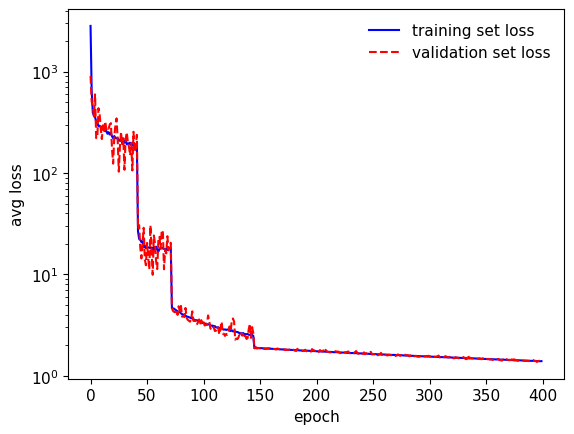

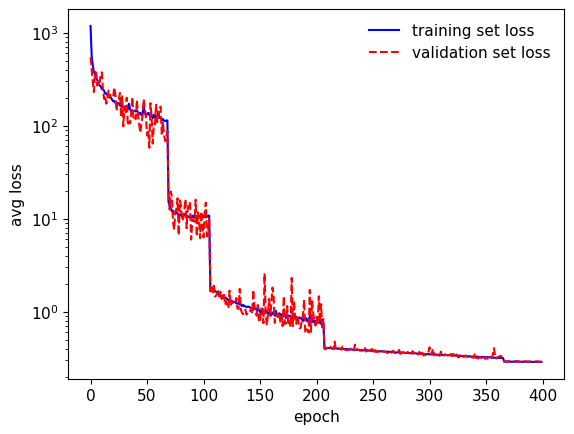

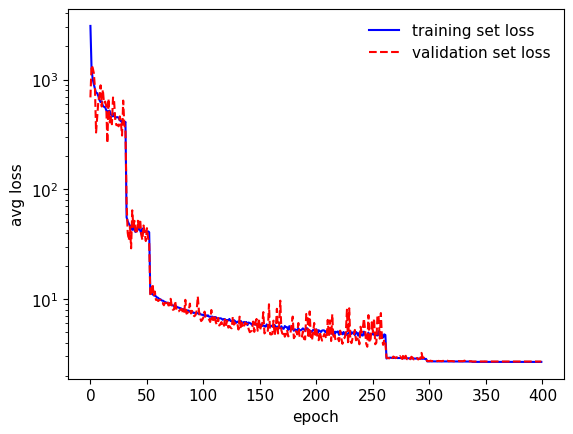

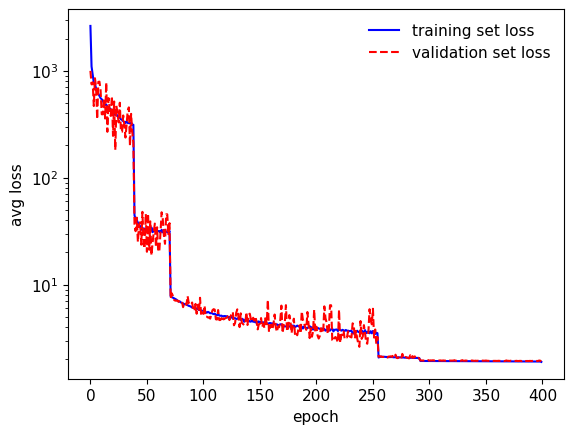

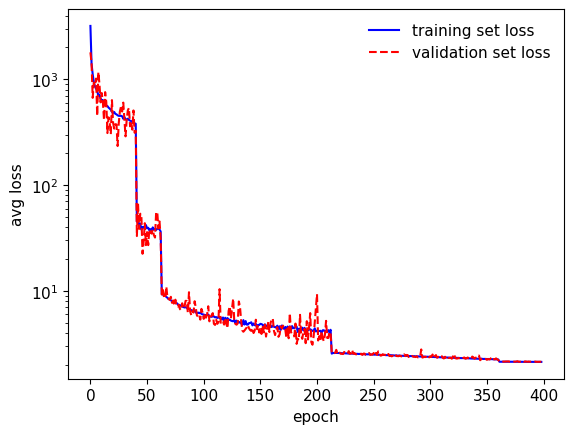

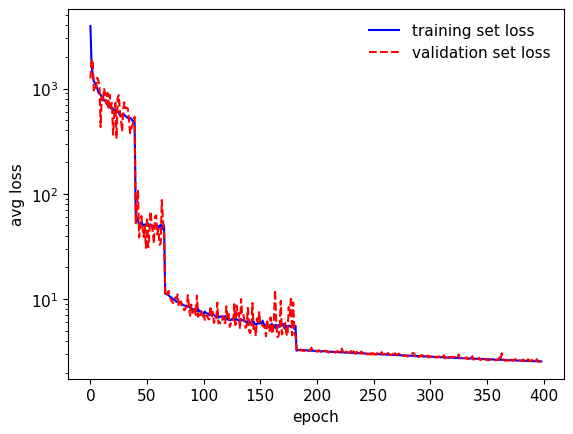

In [6]:
# make plots showing training / validation loss during training
test_loss = calc_avg_loss(emulator.model, test_loader, emulator.input_normalizations, 
                          emulator.ps_fid, emulator.invcov_full, emulator.sqrt_eigvals, emulator.Q, emulator.Q_inv, emulator.loss_function)

for (ps, z) in itertools.product(range(emulator.num_spectra), range(emulator.num_zbins)):
    training_data = torch.load(emulator_dir+"training_statistics/train_data_"+str(ps)+"_"+str(z)+".dat")

    epochs = range(training_data.shape[1])
    train_loss = training_data[0,:]
    valid_loss = training_data[1,:]
    learning_rate = training_data[2,:]
    print("Net [{:d}, {:d}], Total # of epochs    = {:0.0f}".format(ps, z, len(train_loss)))
    print("Net [{:d}, {:d}], Best training loss   = {:0.4f}".format(ps, z, torch.amin(train_loss)))
    print("Net [{:d}, {:d}], Best validation loss = {:0.4f}".format(ps, z, torch.amin(valid_loss)))
    print("Net [{:d}, {:d}], Average test loss    = {:0.4f}\n".format(ps, z, test_loss[ps][z]))
    
    plt.figure()
    plt.plot(epochs, train_loss, c="blue", label="training set loss")
    plt.plot(epochs, valid_loss, c="red", ls="--", label="validation set loss")
    plt.xlabel("epoch")
    plt.ylabel("avg loss")
    plt.yscale("log")
    plt.legend()

In [10]:
# WARNING! This cell can take a while to run!

pk_error = []
error_per_bin = np.zeros((emulator.num_spectra, emulator.num_zbins, emulator.num_ells, emulator.num_kbins))
delta_chi2 = np.zeros((emulator.num_spectra, emulator.num_zbins, len(test_data)))
delta_chi2_combined = np.zeros(len(test_data))

for i in tqdm(range(len(test_data))):

    params = test_data[i][0].to("cpu").detach().numpy()
    pk_raw = test_data.get_normalized_power_spectra(i)

    pk_true = test_data.get_true_power_spectra(i, emulator.ps_fid, emulator.sqrt_eigvals, emulator.Q, emulator.Q_inv).to("cpu").detach()
    pk_pred = emulator.get_power_spectra(params, False)
    pk_pred_raw = emulator.get_power_spectra(params, True)

    #loop thru networks
    for (ps, z) in itertools.product(range(emulator.num_spectra), range(emulator.num_zbins)):
        
        prediction = pk_pred_raw[ps, z].unsqueeze(0)
        target = pk_raw[ps, z].unsqueeze(0)

        chi2 = delta_chi_squared(prediction, target, emulator.invcov_full, True)
        delta_chi2[ps, z, i] = chi2.item()

    delta_chi2_combined[i] = delta_chi_squared(pk_pred, pk_true, emulator.invcov_full, False)
    pk_error.append((pk_pred - pk_true.numpy()) / pk_true)

pk_error = np.array(pk_error)

100%|██████████| 200000/200000 [25:14<00:00, 132.02it/s]


net [0, 0], mean chi2 error = 0.009
net [0, 0], median chi2 error = 0.005
net [0, 1], mean chi2 error = 0.001
net [0, 1], median chi2 error = 0.001
net [1, 0], mean chi2 error = 0.026
net [1, 0], median chi2 error = 0.014
net [1, 1], mean chi2 error = 0.015
net [1, 1], median chi2 error = 0.008
net [2, 0], mean chi2 error = 0.018
net [2, 0], median chi2 error = 0.011
net [2, 1], mean chi2 error = 0.024
net [2, 1], median chi2 error = 0.014


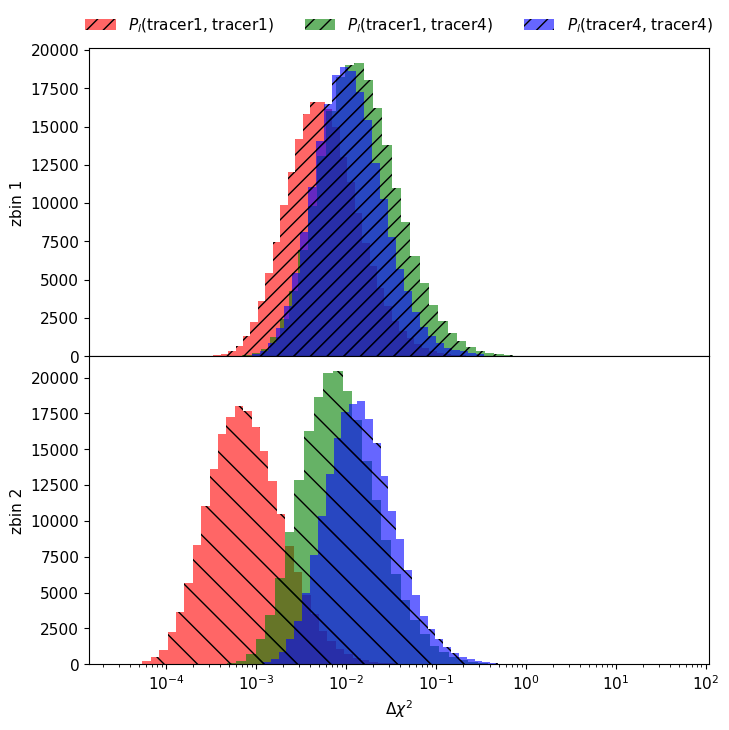

In [11]:
# Plot chi2 histograms for each individual network
labels=[r"$P_l$(tracer1, tracer1)", r"$P_l$(tracer1, tracer4)", r"$P_l$(tracer4, tracer4)"]
cmap = ["red", "green", "blue"]
style = ["//", "\\"]

fig, axs = plt.subplots(2, 1, figsize=(8,8), sharex=True)
for (ps, z) in itertools.product(range(emulator.num_spectra), range(emulator.num_zbins)):
    print("net [{:d}, {:d}], mean chi2 error = {:0.3f}".format(ps, z, np.mean((delta_chi2)[ps, z])))
    print("net [{:d}, {:d}], median chi2 error = {:0.3f}".format(ps, z, np.median(delta_chi2[ps, z])))
    axs[z].hist(delta_chi2[ps, z], bins=np.geomspace(np.amin(delta_chi2[ps, z]), np.amax(delta_chi2[ps, z]), 50), alpha=0.6,
                facecolor=cmap[ps], hatch=style[z], label=labels[ps])
        
axs[0].legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15))
axs[0].set_ylabel("zbin 1")
axs[1].set_ylabel("zbin 2")
plt.xscale("log")
plt.xlabel(r"$\Delta \chi^2$")
plt.subplots_adjust(hspace=0)
plt.savefig("../plots/delta_chi2_histogram.png", dpi=300, bbox_inches='tight')

mean combined chi2 error = 0.501
median combined chi2 error = 0.295


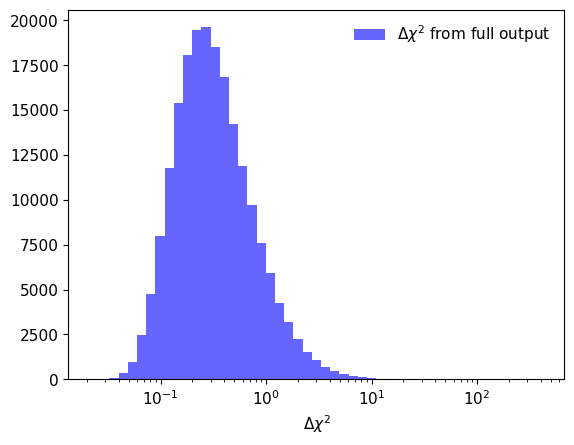

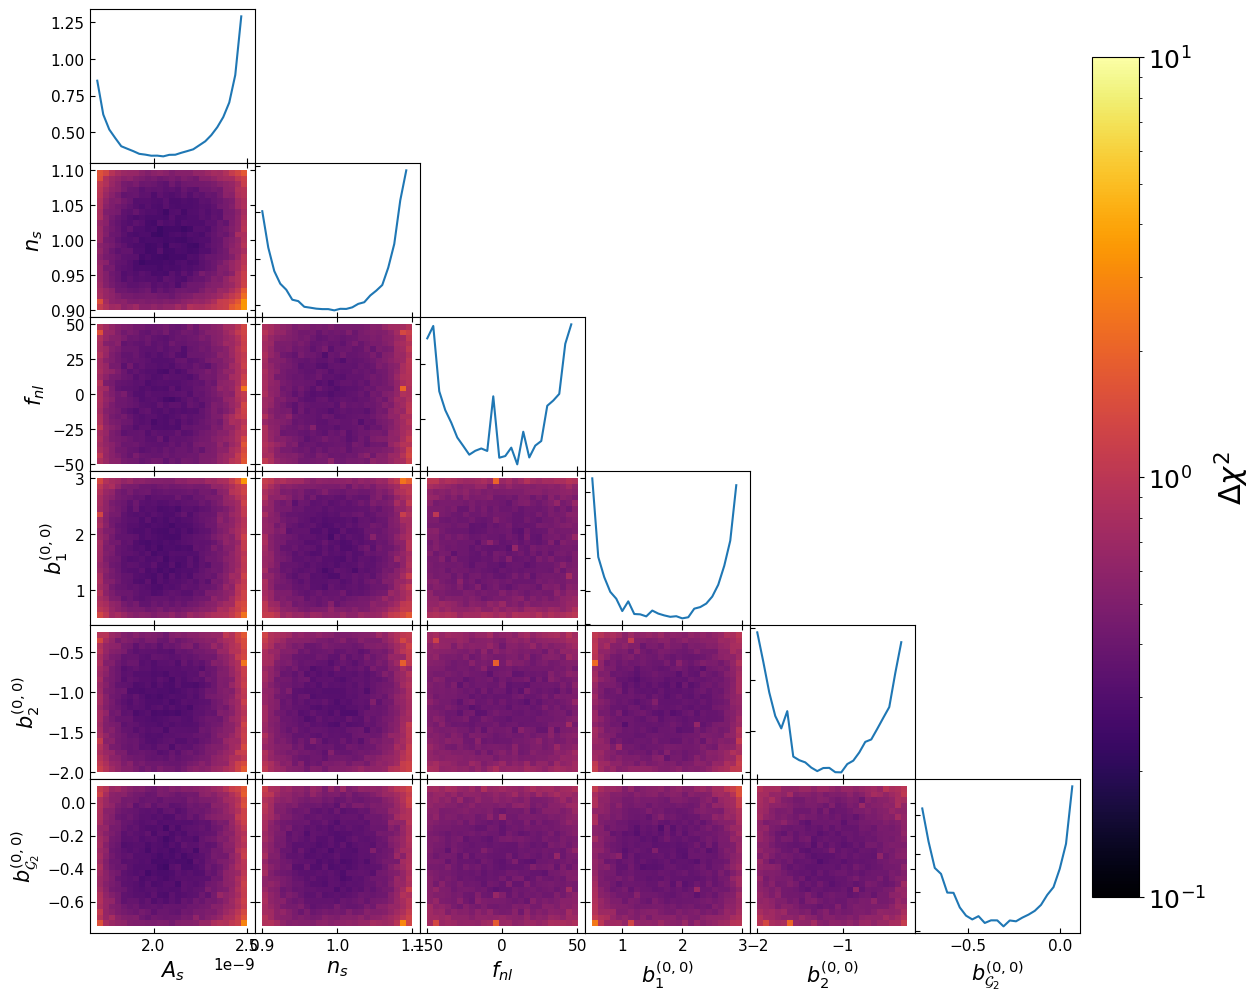

In [12]:
# plot delta chi2 heatmap
# @Grace these plots are the main ones we're using to quantify network performance

print("mean combined chi2 error = {:0.3f}".format(np.mean(delta_chi2_combined)))
print("median combined chi2 error = {:0.3f}".format(np.median(delta_chi2_combined)))

names = ['As', 'ns', 'fnl', 'b1_0_0', 'b2_0_0', 'bG2_0_0']
labels = [r"$A_s$", r"$n_s$", r"$f_{nl}$", r"$b_1^{(0,0)}$", r"$b_2^{(0,0)}$", r"$b_{\mathcal{G}_2}^{(0,0)}$"]

plt.hist(delta_chi2_combined, bins=np.geomspace(np.amin(delta_chi2_combined), np.amax(delta_chi2_combined), 50), alpha=0.6,
                facecolor="blue", hatch="", label=r"$\Delta \chi^2$ from full output")
plt.xscale("log")
plt.xlabel(r"$\Delta \chi^2$")
plt.legend()
plt.savefig("../plots/chi2-histogram-combined.png", dpi=300)

cmap="inferno"
#extents = [2e6, 1e10]
extents = [1e-1, 1e1]
save_str = "../plots/delta_chi2_heatmap.png"
plot_heatmap(test_data.params.to("cpu").detach().numpy(), delta_chi2_combined, r"$\Delta \chi^2$", 
             extents, cmap, True, names, labels, median=False, save_str=save_str)

## Test individual power spectra

Stats for index 126519
input parameters: tensor([ 2.2117e-09,  9.9564e-01, -3.7281e+01,  2.8998e+00,  1.1847e+00,
         2.8540e+00,  1.6301e+00, -1.8700e+00, -6.2668e-01, -1.2051e+00,
        -1.3350e+00, -1.3913e-01, -5.8427e-01, -5.9018e-01, -1.7987e-01,
         3.6294e+01,  1.4977e+01, -3.2942e+01,  7.4280e+01,  4.3374e+01,
         1.5358e+01,  5.5885e+01, -1.2569e+01,  1.9099e+01,  8.2553e+00,
        -6.3506e+00,  1.7902e+01])
torch.Size([3, 2, 50]) torch.Size([3, 2, 50])
Combined Delta chi2 = 4212.122
Net [0, 0], Delta chi2 = 625.576
Net [0, 1], Delta chi2 = 379.062
Net [1, 0], Delta chi2 = 1352.137
Net [1, 1], Delta chi2 = 62.529
Net [2, 0], Delta chi2 = 679.318
Net [2, 1], Delta chi2 = 823.411
Sum of Delta chi2 = 3922.034
Average error per bin = 2.47%
tensor(625.5762)
tensor(379.0620)


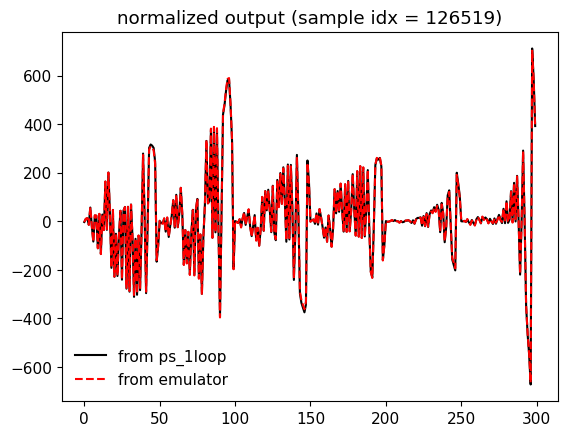

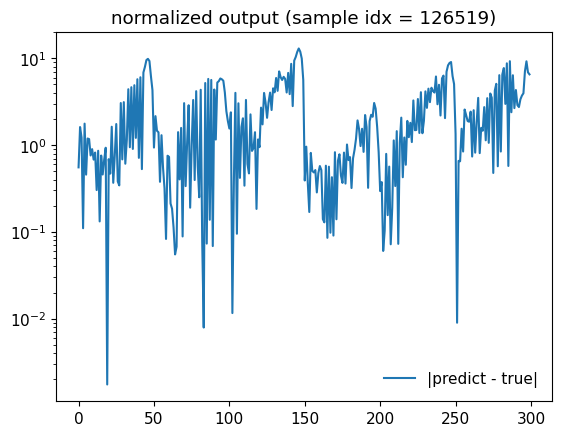

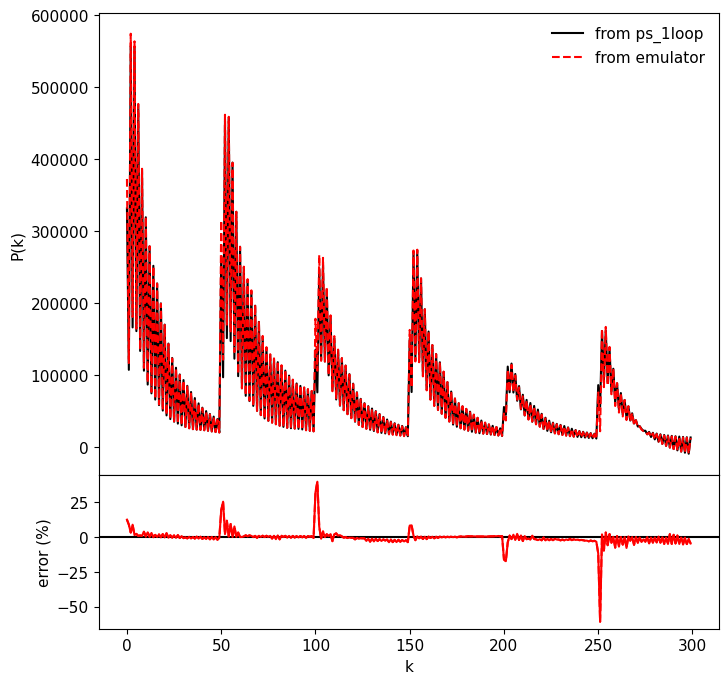

In [8]:
idx = np.random.randint(len(test_data))
print("Stats for index {:d}".format(idx))

params = test_data[idx][0].to("cpu")
pk_emu = emulator.get_power_spectra(params.detach().numpy(), False)
pk_emu_raw = emulator.get_power_spectra(params.detach().numpy(), True)
pk_raw = test_data.get_normalized_power_spectra(idx)
pk_true = test_data.get_true_power_spectra(idx, emulator.ps_fid, 
                                                emulator.sqrt_eigvals, 
                                                emulator.Q, 
                                                emulator.Q_inv).detach().numpy()
print("input parameters:", params)

print(pk_emu_raw.shape, pk_raw.shape)
error = 100 * (pk_emu - pk_true) / pk_true

chi2_full = delta_chi_squared(pk_emu, pk_true, emulator.invcov_full, False)
print("Combined Delta chi2 = {:0.3f}".format(chi2_full))

#Calculate delta chi2 for each network seperately
d_chi2_sum = 0
for (ps, z) in itertools.product(range(emulator.num_spectra), range(emulator.num_zbins)):
    d_chi2 = delta_chi_squared(pk_emu_raw[ps, z].unsqueeze(0), pk_raw[ps, z].unsqueeze(0), emulator.invcov_blocks, True)
    d_chi2_sum += d_chi2
    print("Net [{:d}, {:d}], Delta chi2 = {:0.3f}".format(ps, z, d_chi2))
print("Sum of Delta chi2 = {:0.3f}".format(d_chi2_sum))

print("Average error per bin = {:0.2f}%".format(np.mean(abs(error))))

plt.figure()
plt.title("normalized output (sample idx = "+str(idx)+")")
plt.plot(pk_raw.flatten(), c="black", label="from ps_1loop")
plt.plot(pk_emu_raw.flatten(), c="red", ls="--", label="from emulator")
plt.legend() 
plt.savefig("../plots/emu_output_1.png", dpi=200)

plt.figure()
plt.title("normalized output (sample idx = "+str(idx)+")")
plt.plot(abs(pk_raw - pk_emu_raw).flatten(), label="|predict - true|")
plt.yscale("log")
plt.legend()
plt.savefig("../plots/emu_output_2.png", dpi=200)

delta = pk_raw.flatten()[:50] - pk_emu_raw.flatten()[:50]
print(torch.dot(delta, delta))
delta = pk_raw.flatten()[50:100] - pk_emu_raw.flatten()[50:100]
print(torch.dot(delta, delta))

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(pk_true.flatten(), c="black", label="from ps_1loop")
#axs[0].plot(pk_true[:,0].flatten(), c="green", ls="--")
axs[0].plot(pk_emu.flatten(),  c="red", ls="--", label="from emulator")
axs[1].axhline(0, c="black")
axs[1].plot(error.flatten(), c="red")
axs[1].plot(error.flatten(), c="red", ls="--")

axs[1].set_xlabel("k")
axs[0].set_ylabel("P(k)")
axs[1].set_ylabel("error (%)")
axs[0].legend()
fig.subplots_adjust(hspace=0)

In [ ]:
# Sanity Check: make sure two different samples to see if the network outputs different results
idx_1 = np.random.randint(len(test_data))
idx_2 = np.random.randint(len(test_data))

params = test_data[idx_1][0].to("cpu")
pk_emu_1 = emulator.get_power_spectra(params.detach().numpy())
params = test_data[idx_2][0].to("cpu")
pk_emu_2 = emulator.get_power_spectra(params.detach().numpy())

fig, axs = plt.subplots(1, 1, figsize=(7, 6), sharex=True)

axs.plot(pk_emu_1.flatten(),  c="red", label="idx = " + str(idx_1))
axs.plot(pk_emu_2.flatten(),  c="blue", ls="--", label="idx = " + str(idx_2))
#axs[0].plot(k, data_vector[25:], c="blue", ls="--")

axs.set_ylabel("P(k)")
axs.legend()
fig.subplots_adjust(hspace=0)